Using TensorFlow backend.


------------------------ Let's get the party started! -------------------------------------
../data/macro_economy//china_macro_economy_daily.csv
../data/macro_economy//OECD-world-economy-daily.csv
../data/components//components-top10.csv
../data/000300.SH/000300.SH.csv ===============
Factors Shape: (2671, 135)
---- Trend Distribution Check --------
0.0     960
1.0     558
2.0    1153
dtype: int64
input data shape:  (2671, 135)
input label shape:  (2671,)


/usr/local/lib/python3.5/dist-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


prediction model input data shape:  (2663, 8)
train sample:  2360 data_dim 8
training size:  2360
testing size:  280
Train on 2360 samples, validate on 280 samples
Epoch 1/100
2360/2360 [==============================] - 6s - loss: 1.0784 - acc: 0.4568 - val_loss: 1.0099 - val_acc: 0.5750
Epoch 2/100
2360/2360 [==============================] - 5s - loss: 0.9955 - acc: 0.5390 - val_loss: 0.8779 - val_acc: 0.6214
Epoch 3/100
2360/2360 [==============================] - 5s - loss: 0.9450 - acc: 0.5826 - val_loss: 0.8563 - val_acc: 0.6500
Epoch 4/100
2360/2360 [==============================] - 5s - loss: 0.9373 - acc: 0.5873 - val_loss: 0.8892 - val_acc: 0.6393
Epoch 5/100
2360/2360 [==============================] - 5s - loss: 0.9195 - acc: 0.5843 - val_loss: 0.8464 - val_acc: 0.6214
Epoch 6/100
2360/2360 [==============================] - 5s - loss: 0.9120 - acc: 0.5932 - val_loss: 0.8643 - val_acc: 0.6321
Epoch 7/100
2360/2360 [==============================] - 5s - loss: 0.8949 - acc

2360/2360 [==============================] - 5s - loss: 0.8054 - acc: 0.6572 - val_loss: 0.8130 - val_acc: 0.6679
Epoch 65/100
2360/2360 [==============================] - 5s - loss: 0.7981 - acc: 0.6496 - val_loss: 0.8255 - val_acc: 0.6607
Epoch 66/100
2360/2360 [==============================] - 5s - loss: 0.8166 - acc: 0.6449 - val_loss: 0.8318 - val_acc: 0.6571
Epoch 67/100
2360/2360 [==============================] - 5s - loss: 0.8135 - acc: 0.6381 - val_loss: 0.8039 - val_acc: 0.6679
Epoch 68/100
2360/2360 [==============================] - 5s - loss: 0.7958 - acc: 0.6564 - val_loss: 0.8119 - val_acc: 0.6536
Epoch 69/100
2360/2360 [==============================] - 6s - loss: 0.8086 - acc: 0.6504 - val_loss: 0.8473 - val_acc: 0.6571
Epoch 70/100
2360/2360 [==============================] - 5s - loss: 0.8033 - acc: 0.6534 - val_loss: 0.8104 - val_acc: 0.6786
Epoch 71/100
2360/2360 [==============================] - 5s - loss: 0.8005 - acc: 0.6568 - val_loss: 0.8192 - val_acc: 0.66

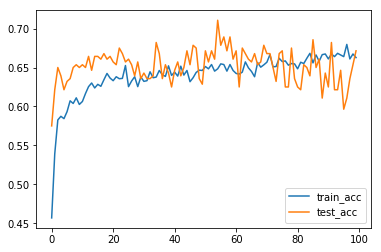

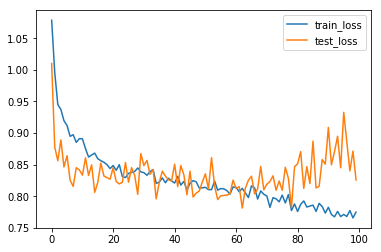

In [1]:
'''
Testing GUR
'''
from keras.models import Model, Sequential, load_model
from keras.layers import Input, LSTM, RepeatVector, GRU
from keras.layers import Dense, Dropout
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
'''
Preparing data
'''
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import math

'''
Reading Macro economy factors from CSV
Notice: data are distributed monthly, need to be filled for daily usage
'''
def strip_comma(x):
    return float(str(x).replace(',',''))
def read_macro_economy(base_dir = '../data/macro_economy/', 
                       filename = 'china_macro_economy_daily.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(31)],
                       usecols = None):
    filename = base_dir +'/'+ filename
    print (filename) #中文读取出问题，所以skip row1
    df = pd.read_csv(filename, index_col=0, sep=',', 
                     skiprows=1, usecols=usecols,
                     names = names, parse_dates=True,
                     converters = {11: strip_comma, 22: strip_comma}
                    )
    return df[start_date : end_date]


'''
Reading World economy factors sponsored by OECD from CSV
Notice: data are distributed monthly, need to be filled for daily usage
'''
def read_world_economy(base_dir = '../data/macro_economy/', 
                       filename = 'OECD-world-economy-daily.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(46)],
                       usecols = None):
    filename = base_dir +'/'+ filename
    print (filename) 
    df = pd.read_csv(filename, index_col=0, 
                     skiprows=1, usecols=usecols,parse_dates=True,
                     names = names
                    )
    return df[start_date : end_date]

'''
Reading Top10 Components CSV
Data has been assigned weight according to their ratio in the market

# Ref: data calculated from data/generate/FetchingComponentsData.ipynb
'''
def read_components(base_dir = '../data/components/', 
                       filename = 'components-top10.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(10)]):
    filename = base_dir +'/'+ filename
    print (filename) 
    df = pd.read_csv(filename, index_col=0, 
                     skiprows=1,parse_dates=True,
                     names = names
                    )
    df = df.fillna(0)
    return df[start_date : end_date]

'''
Reading ohlcv transaction data for a stock

'''
def readWSDFile(baseDir, stockCode, startDate='2005-01-04', endDate= '2015-12-31', usecols=None, 
                names=['date','pre_close','open','high','low','close','change','chg_range',
                                               'volume','amount','turn']):
    # 解析日期
    filename = baseDir+stockCode+'/'+stockCode+'.csv'
    print (filename, "===============")
    dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d').date()
    df = pd.read_csv(filename, index_col=0, sep=',', header=None,usecols=usecols,
                            skiprows=1, names=names,
                           parse_dates=True, date_parser=dateparse)
    df = df.fillna(0)
    return df[startDate : endDate]

'''
Reading Technical indicators of a stock
'''
def readWSDIndexFile(baseDir, stockCode, startYear, yearNum=1):
    # parse date
    dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d').date()

    df = 0
    for i in range(yearNum):
        tempDF = pd.read_csv(baseDir+'I'+stockCode+'/wsd_'+stockCode+'_'+str(startYear+i)+'.csv', index_col=0, sep=',', parse_dates=True, date_parser=dateparse
                             # , usecols=usecols
                             )
        if i==0: df = tempDF
        else: df = df.append(tempDF)
    df = df.fillna(0)
    return df

'''
Preparing all the useful data
'''
# 整理好多因子输入，以dataframe返回数据+标签
def data_prepare(retrace = 0.618, dtype = 'all', start_date='2005-01-04', end_date= '2015-12-31'):
    # prepare data
    baseDir = '../data/'
    stockCodes = ['000300.SH']
    i = 0
    startYear = 2005
    number =11
    print("------------------------ Let's get the party started! -------------------------------------")
    ## Load data from CSV
    dfm = read_macro_economy(start_date = start_date, end_date = end_date)
    dfw = read_world_economy(start_date = start_date, end_date = end_date)
    dfc = read_components(start_date = start_date, end_date = end_date)
    df = readWSDFile(baseDir, stockCodes[i], start_date, end_date)
    dfi = readWSDIndexFile(baseDir, stockCodes[i], startYear, number)
    allDF = df
    if dtype == 'all':
        allDF = pd.concat([df, dfi, dfm, dfw, dfc], axis=1)
    elif dtype == 'only_m':
        allDF = pd.concat([df, dfm], axis=1) # macro economy 
    elif dtype == 'only_i':
        allDF = pd.concat([df, dfi], axis=1) # technical indicators
    elif dtype == 'only_w':
        allDF = pd.concat([df, dfw], axis=1) # world economy
    elif dtype == 'only_c':
        allDF = pd.concat([df, dfc], axis=1) # constitutant stock
    elif dtype == 'im':
        allDF = pd.concat([df, dfi, dfm], axis=1) 
    elif dtype == 'ic':
        allDF = pd.concat([df, dfi, dfc], axis=1) 
    else:
        pass
    allDF = allDF.fillna(0)
    sample_num = np.shape(df)[0]
    labelDF = pd.Series(np.zeros(sample_num))
    print ("Factors Shape:", np.shape(allDF))
    
    # 求出 trend
    price = df['close']
    start = 0
    while price[start] > price[start+1]:
        labelDF[start] = 1 #flat
        start +=1
    
    #find peak, find trough, calculate retracement and label trend accordingly
    i = start
    while i < sample_num - 1:
        cursor = i
        while cursor < sample_num - 1 and price[cursor] <= price[cursor+1]:
            cursor += 1
        peak = cursor
        while cursor < sample_num - 1 and price[cursor] >= price[cursor+1]:
            cursor += 1
        trough = cursor
        retracement = (price[peak] - price[trough]) / (price[peak] - price[i])
        mark = 1 # flat
        if retracement < retrace:
            mark = 2 # UP
        elif retracement > 1 + retrace:
            mark = 0 # DOWN
        for k in range(i, cursor+1):
            labelDF[k] = mark
        i = cursor

    print("---- Trend Distribution Check --------")
    print(labelDF.value_counts().sort_index())
    
    # make a deep copy of Price Difference before normalizing
    priceDF = allDF['change'].copy(deep=True)
    # normalize(x)
    scaler = preprocessing.MinMaxScaler()
    input_data = scaler.fit_transform(allDF)
    print ("input data shape: ", np.shape(input_data)) #  days *  factors
    print ("input label shape: ", np.shape(labelDF))
    labels = labelDF.values
    #input_data = np.concatenate((input_data, labels.reshape(-1,1)), axis = 1) # historical data as part of the series
    return input_data, labels, priceDF, price # train/test data, labels, prices difference, actual price for yield calucluation


###### Hyper paramters #########
time_steps = 8
n_neurons = 200
num_classes = 3
batch_size = 20 # specify batch size explicitly; no shuffle but successive sequence
n_epoch_ae = 30
n_epoch = 100
train_ratio = 0.9
dropout = 0.4
concate = False # without using historical labels as input data
t0 = time()
dataset,labels, priceDF, price = data_prepare()
segment_num = (len(dataset) - time_steps - 1) // batch_size # rollingly use data
train_size = int(segment_num * train_ratio)
test_size = segment_num - train_size
data_dim = np.shape(dataset)[1] #input + historic labels
'''
#divide training/validation dataset; numpy array
train_x = dataset[0 : train_size * batch_size + time_steps]
test_x = dataset[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]

#historic label as input time series
train_historic_label = np.array(labels[0 : train_size * batch_size + time_steps]).reshape(-1,1)
test_historic_label = np.array(labels[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]).reshape(-1,1)

#Sliding window: label is just 1 step further after sequence data
train_y = labels[time_steps : train_size * batch_size + time_steps]
test_y = labels[train_size * batch_size + time_steps: (train_size + test_size) * batch_size + time_steps]

# add historical trends or not
if concate:
    data_dim += 1
    train_x = np.concatenate((train_x, train_historic_label), axis = 1)
    test_x = np.concatenate((test_x, test_historic_label), axis = 1)

train_sample = len(train_x) - time_steps
b = np.array([[]])
# creating data in a rolling window view 
for i in range(train_sample):
    b = np.append(b, train_x[i : time_steps + i])
train_x = b.reshape(train_sample, time_steps, data_dim)
print("training size: ", train_sample)

test_sample = len(test_x) - time_steps
b = np.array([[]])
for i in range(test_sample):
    b = np.append(b, test_x[i : time_steps + i])
test_x = b.reshape(test_sample, time_steps, data_dim)
print("testing size: ", test_sample)

train_y = np.array(train_y, dtype=np.int32)
test_y = np.array(test_y, dtype=np.int32)

############## AutoEncoder MODEL ##########################
latent_dim = 8
layer1 = 128
layer2 = 32
layers = [layer2,layer1]
inputs = Input(shape=(time_steps, data_dim))
encoded = LSTM(units = layer1, return_sequences = True)(inputs)
encoded = LSTM(units = layer2, return_sequences = True)(encoded)
encoded = LSTM(units = latent_dim, return_sequences = False)(encoded) # most hidden layer, only preseve the last step's output

repeated_out = RepeatVector(time_steps)(encoded)  # repeat intermediate output [2D -> 3D]

decoded = LSTM(layer2, return_sequences=True)(repeated_out)
decoded = LSTM(layer1, return_sequences=True)(decoded)
decoded = LSTM(data_dim, return_sequences=True)(decoded)  # output layer as a comparison

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)  ## encoder for dimensionality reduction

sequence_autoencoder.compile(optimizer='rmsprop', 
                             loss='mean_squared_error',
                             )
history = sequence_autoencoder.fit(x = train_x, y = train_x, 
                         batch_size=batch_size,
                         epochs=n_epoch_ae,
                         shuffle=False,
                         validation_data = (test_x, test_x))
print ("Params: ", "time_steps:", time_steps, " latent_dim:", 
       latent_dim, " batch_size: ",batch_size, " n_epoch: ", 
       n_epoch, 'layers', layers, "\n Time cost: ", (time() - t0))

encoder.save('autoencoder-135d-8ts-100ep-128-32-8.h5')
compressed_data = encoder.predict(dataset)

'''
## load model from file
encoder = load_model('autoencoder-135d-8ts-100ep-128-32-8.h5')
# rolling window
b = np.array([[]])
n_sample = len(dataset) - time_steps
for i in range(n_sample):
    b = np.append(b, dataset[i : time_steps + i])
dataset = b.reshape(n_sample, time_steps, data_dim)
compressed_data = encoder.predict(dataset)


dataset = compressed_data

################################################################
########### Prediction Model ###################################
# divide training/validation dataset 
segment_num = (len(dataset) - time_steps - 1) // batch_size # rollingly use data
train_size = int(segment_num * train_ratio)
test_size = segment_num - train_size
data_dim = np.shape(dataset)[1]
print ("prediction model input data shape: ", np.shape(dataset)) 

#divide training/validation dataset; numpy array
train_x = dataset[0 : train_size * batch_size + time_steps]
test_x = dataset[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]
# rolling window
train_sample = len(train_x) - time_steps
print ("train sample: ", train_sample, "data_dim",data_dim)
b = np.array([[]])
for i in range(train_sample):
    b = np.append(b, train_x[i : time_steps + i])
train_x = b.reshape(train_sample, time_steps, data_dim)
print("training size: ", train_sample)

test_sample = len(test_x) - time_steps
b = np.array([[]])
for i in range(test_sample):
    b = np.append(b, test_x[i : time_steps + i])
test_x = b.reshape(test_sample, time_steps, data_dim)
print("testing size: ", test_sample)

#Sliding window: label is just 1 step further after sequence data
train_y = labels[time_steps : train_size * batch_size + time_steps]
test_y = labels[train_size * batch_size + time_steps: (train_size + test_size) * batch_size + time_steps]
train_y = np.array(train_y, dtype=np.int32)
test_y = np.array(test_y, dtype=np.int32)


layers = 5
early_stop = EarlyStopping(monitor='val_loss',patience = 40, mode='min') #when it stops deacreasing, stop
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(GRU(n_neurons, return_sequences=True,stateful=True,dropout = dropout,
               batch_input_shape=(batch_size, time_steps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(GRU(n_neurons, return_sequences=True,dropout = dropout, stateful=True))  # returns a sequence of vectors of dimension 32
model.add(GRU(n_neurons, return_sequences=True,dropout = dropout, stateful=True)) 
model.add(GRU(n_neurons, dropout = dropout,stateful=True))  # return a single vector of dimension 32
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', #for integer class, not one hot encoding
              optimizer='rmsprop',
              metrics=['accuracy'])   

history = model.fit(train_x, train_y,
          batch_size=batch_size, 
          epochs=n_epoch,
          shuffle=False,
          validation_data=(test_x, test_y),
          callbacks = [early_stop]         
                   )

print ("Params: ", "time_steps:", time_steps, "  n_neurons:", n_neurons, 
       " batch_size: ",batch_size, " n_epoch: ", n_epoch, 'layers',
       layers, "\n Time cost: ", (time() - t0))
print("Add Dropout between every layer: ",dropout)
print('Avg. Train ACC = ', np.average(history.history['acc']))
print('Avg. Test ACC = ', np.average(history.history['val_acc']))
# plot history

plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='test_acc')
plt.legend()
plt.show()
# loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()


# prediction check & visualization
#model.save('classifier.h5')


In [2]:
print('Avg. Train loss = ', np.average(history.history['loss']))
print('Avg. Test loss = ', np.average(history.history['val_loss']))

Avg. Train loss =  0.825605018368
Avg. Test loss =  0.835865304917
